In [1]:
import torch
from torchvision import datasets,transforms
from torch.utils.data import DataLoader
from argparse import Namespace

from torch import nn
from dataloader import load_data
from tqdm import tqdm
device='cuda:7'

train_inputs,train_lables,test_inputs,test_lables=load_data(300000,300000,device=torch.device(device))




load data set
create loader
construct data


100%|██████████| 1/1 [00:08<00:00,  8.87s/it]


In [ ]:
device='cuda:7'
def self_detection(model:nn.Module,batch_size,useorigin=False):
    model.to(device)
    if(useorigin):
        return test_inputs,test_lables
    output=torch.tensor([])
    output_label=torch.tensor([]).to(device)
    origin_output=torch.tensor([]).to(device)
    for i_layer,layer in enumerate(reversed(model.layers)):
        if(isinstance(layer,torch.nn.Linear)):
            w=layer.weight
            b=layer.bias
            # b=b.repeat(batch_size)
            U,S,V=torch.linalg.svd(w.t())
            # print(U.device)
            r=len(S)
            U=U[:,:r]
            S=torch.diag(S)
            V=V[:r,:]


            if(output.numel()==0):
                output=torch.rand(batch_size,w.shape[0])*10
                output=output.to(device)
                max_index=output.argmax(dim=1)
                
                output[torch.arange(batch_size), max_index] = 50
                # origin_output.append(output)
                if(origin_output.numel()==0):
                    origin_output=output
                else:
                    origin_output=torch.cat((origin_output,output),dim=0)
                
                output_label=torch.tensor(max_index.long(),dtype=torch.long).to(device)
            output=output-b
            output=torch.matmul(output,V.t())
            output=torch.matmul(output,S.inverse())
            output=torch.matmul(output,U.t())
        if(isinstance(layer,torch.nn.ReLU)):
            # output=torch.relu(output)
            zero_indice=torch.where(output==0)
            max_=torch.max(output)
            max_=max_.to('cuda:7')
            output[zero_indice]=(torch.rand(len(zero_indice[0])).to(device)*-max_).to(device)
        if(isinstance(layer,nn.LeakyReLU)):
            alpha=layer.negative_slope
            output=torch.where(output>0,output,output/(100*alpha))
            mu, sigma = torch.mean(output), torch.std(output)
            output = (output - mu) / sigma
    # print(output)
    output=output.reshape(-1,28,28)
    # print(output.shape)
    # print(output_label.shape)
    normalize=transforms.Normalize((0.5,), (0.5,))
    output=normalize(output)
    return output,output_label
    # return output,origin_output


def self_detection_random(model:nn.Module,batch_size,input_size,use_origin=False):
    model.eval()
    model.to('cuda:7')
    if(use_origin):
        model_output=[]
        model_input=[]
        for batch in test_inputs:
            batch.to('cuda:7')
            output=model(batch)
            model_input.append(batch)
            model_output.append(output)
        return model_input,model_output
    import time
    seed = time.time()
    torch.manual_seed(seed)
    model.to(device)
    ip=torch.randn(batch_size,input_size,input_size)
    ip=ip.to(device)
    output=model.forward(ip)
    # print(ip.shape)
    # print(output.argmax(dim=1))
    return ip,output

    


In [99]:
import torch
import model
# from model import Bias
from torch import nn
import importlib
# importlib.reload(model)


def acc(model,input,test_lables,use_origin):
    if(use_origin):
        model.eval()
        correct=0
        total=0
        with torch.no_grad():
            for i in range(len(input)):
                outputs=model(input[i].reshape(1,-1))
                _,predicted=torch.max(outputs.data,1)
                total+=len(predicted)
                correct+=(predicted==test_lables[i]).sum().item()
            return correct/total
    model.eval()
    correct=0
    total=0
    with torch.no_grad():
        
        
        outputs=model(input)
        _,predicted=torch.max(outputs.data,1)
        total+=len(predicted)
        correct+=(predicted==test_lables).sum().item()
    return correct/total

def acc_loss(model,input,test_lables,use_origin=False):
    model.eval()
    loss=0

    if(use_origin):
        for i in range(len(input)):
            outputs=model(input[i])
            loss+=nn.CrossEntropyLoss()(outputs,test_lables[i].softmax(dim=1)).item()
        return loss/len(input)

    with torch.no_grad():
        outputs=model(input)
        loss=nn.CrossEntropyLoss()(outputs,test_lables.softmax(dim=1))
    return loss

mlp = torch.load('./mlp2.pth')
print(len(mlp.layers))


def svd(reduce,bound,k_down):
    for k,layer in enumerate(mlp.layers):
        if (isinstance(layer, torch.nn.Linear)):
            w=layer.weight
            b=layer.bias
            U,S,V=torch.linalg.svd(w.t())

            sort_index=torch.argsort(S)
            cnt=0
            sum=0
            for i in S.view(-1):
                sum+=i.item()
                if(i.item()<reduce):
                    cnt+=1
            
            if (len(S)<bound):
                continue
            print(f"reduced{k}:{cnt/len(S)}")
            index_remove=sort_index[:cnt]
            # input()

            Vn_mask=torch.ones(V.size(0),dtype=torch.bool)
            Vm_mask=torch.ones(V.size(1),dtype=torch.bool)
            Un_mask=torch.ones(U.size(0),dtype=torch.bool)
            Um_mask=torch.ones(U.size(1),dtype=torch.bool)
            S_mask=torch.ones(S.size(0),dtype=torch.bool)
            for removei in index_remove:
                Vn_mask[removei]=False
                Vm_mask[removei]=False
                Un_mask[removei]=False
                Um_mask[removei]=False
                S_mask[removei]=False
            V=V[Vn_mask,:]
            U=U[:,Un_mask]
            S=S[S_mask]

            # from matplotlib import pyplot as plt

            # ls=[]
            # for x in S.view(-1):
            #     ls.append(x.item())
            # plt.scatter(np.arange(len(S)),ls,color='blue',marker='x',s=50)
            # plt.show()
            
            nU=U.shape[0]
            mU=U.shape[1]
            nV=V.shape[0]
            mV=V.shape[1]
            nS=mU
            mS=nV

            S_diag = torch.zeros(nS,mS)
            for i in range(S.shape[0]):
                S_diag[i, i] = S[i]
            S=S_diag


            newlinear1=torch.nn.Linear(nU,mU,bias=False).to(device)
            newlinear2=torch.nn.Linear(nS,mS,bias=False).to(device)
            newlinear3=torch.nn.Linear(nV,mV,bias=False).to(device)
            newlinear1.weight=nn.Parameter(U.t())
            newlinear2.weight=nn.Parameter(S.t())
            newlinear3.weight=nn.Parameter(V.t())
            newbias=model.Bias(b)
            newbias=newbias.to(device)
            # print(newlinear1.weight.shape)
            # print(newlinear2.weight.shape)
            # print(newlinear3.weight.shape)
            # print('------------')
            svded=nn.Sequential(newlinear1,newlinear2,newlinear3,newbias)
            mlp.layers[k]=svded

from matplotlib import pylab as plt
y=[]
import numpy as np
bound=700
k_down=0
for i in np.arange(2, 0, -0.05):
    mlp = torch.load('./mlp2.pth')
    
    
    # test_data,lable=self_detection_random(mlp,100000,28)
    test_data,lable=self_detection(mlp,1000,False)
    svd(i,bound,k_down)
    mlp.eval()
    mlp.to(device)
    # for layer in mlp.layers:
    #     if(isinstance(layer,torch.nn.Sequential)):
    #         for sublayer in layer:
    #             sublayer.to(device)
    #             if(not isinstance(sublayer,nn.Module)):
    #                 print(sublayer.weight.shape)
        # print('----------------')
    print()
    print(acc(mlp,test_data,lable,False))
    y.append(acc(mlp,test_data,lable,False))
    # print(acc_loss(mlp,test_data,lable).item())
    # y.append(acc_loss(mlp,test_data,lable).item())




/tmp/ipykernel_2250411/2399851697.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mlp = torch.load('./mlp2.pth')
/tmp/ipykernel_2250411/2399851697.py:130: FutureWarning

9
reduced0:0.7423469387755102

0.239
reduced0:0.7244897959183674

0.313
reduced0:0.7066326530612245

0.395
reduced0:0.6875

0.375
reduced0:0.6683673469387755

0.319
reduced0:0.6479591836734694

0.317
reduced0:0.6288265306122449

0.299
reduced0:0.6096938775510204

0.333
reduced0:0.5880102040816326

0.333
reduced0:0.5676020408163265

0.376
reduced0:0.5471938775510204

0.293
reduced0:0.5255102040816326

0.374
reduced0:0.5051020408163265

0.487
reduced0:0.48214285714285715

0.488
reduced0:0.4642857142857143

0.492
reduced0:0.4413265306122449

0.557
reduced0:0.41964285714285715

0.598
reduced0:0.3979591836734694

0.575
reduced0:0.375

0.602
reduced0:0.35331632653061223

0.518
reduced0:0.33035714285714285

0.547
reduced0:0.30739795918367346

0.544
reduced0:0.2857142857142857

0.573
reduced0:0.2653061224489796

0.582
reduced0:0.23979591836734693

0.6
reduced0:0.2193877551020408

0.566
reduced0:0.19642857142857142

0.628
reduced0:0.17346938775510204

0.646
reduced0:0.15051020408163265

0.687
r

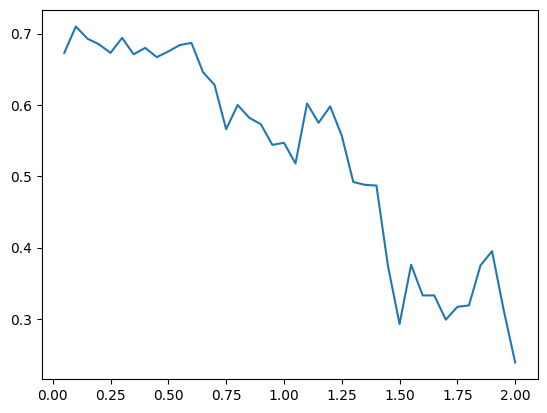

In [100]:
x=np.arange(2, 0, -0.05)
plt.plot(x,y)
plt.show()

In [ ]:
x=np.arange(1, 0, -0.001)
plt.plot(x,y)
plt.show()